# ADVI Inference of a near genome-scale kinetic model from multiomics data

This notebook contains the analysis of the ADVI results on the data from Hackett et al, 2016 [1], analyzed with the yeast model from Jol et al., 2012 [2]. The actual model construction and inference are perfomed in a separate python file, `run_hackett_inference.py`.

1. Hackett, S.R., Zanotelli, V.R.T., Xu, W., Goya, J., Park, J.O., Perlman, D.H., Gibney, P.A., Botstein, D., Storey, J.D., and Rabinowitz, J.D. (2016). Systems-level analysis of mechanisms regulating yeast metabolic flux. Science 354, aaf2786–aaf2786.
2. Jol, S.J., Kümmel, A., Terzer, M., Stelling, J., and Heinemann, M. (2012). System-level insights into yeast metabolism by thermodynamic analysis of elementary flux modes. PLoS Computational Biology 8, e1002415.

In [1]:
import sys
sys.version

'3.6.5 |Intel Corporation| (default, Aug  3 2018, 14:28:11) \n[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]'

In [2]:
from run_hackett_inference import *

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True)

from tqdm import tqdm

%matplotlib inline

In [4]:
r_labels = [r.id for r in model.reactions]

In [6]:
import gzip
import pickle


with gzip.open('data/hackett_results.p.gz', 'rb') as f:
    advi = pickle.load(f)

plot of ELBO convergence vs iteration

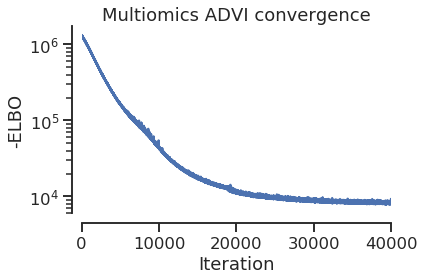

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.semilogy(advi['hist'].hist, '-', ms=1, rasterized=True)
ax.set_xlim([0, 40000])

sns.despine(offset=10)
ax.set_xlabel('Iteration')
ax.set_ylabel('-ELBO')
ax.set_title('Multiomics ADVI convergence')

plt.tight_layout()

# plt.savefig('hackett_advi.svg')

In [8]:
trace = advi['trace']

In [9]:
def plot_hpd(ax, real, ppc, error=True, ms=3, alpha=0.5, color='b'):
    if error:
        ax.plot(np.vstack([real.values.flatten(), real.values.flatten()]),
                pm.hpd(ppc).reshape(-1, 2).T, color=color, lw=1, alpha=0.05, zorder=0)
    ax.plot(real, np.median(ppc, 0), '.', ms=ms, color=color, alpha=alpha, zorder=0)

Metabolites are given in relative concentrations, which actually works perfectly for this analysis.

Specifically, the concentrations are given by $$x = A 2^a,$$ where $A$ is `Conversion_to_Absolute` and $a$ are the columns of `metabolites`.

For a given reference state $x^* = A 2^b,$ $$\chi = \log(\frac{x}{x^*}) = \log\left(\frac{A 2^a}{A 2^b}\right) = (a - b) \log 2$$

Therefore we can calculate values of $\chi$ even when absolute metabolite concentrations aren't known.
Enzymes are also reported as $\log_2$ transformed variables.
For $\hat{e}$, we need $$\frac{e}{e^*} = \frac{A 2^{y}}{A 2 ^{y^*}} = 2^{y - y^*}$$

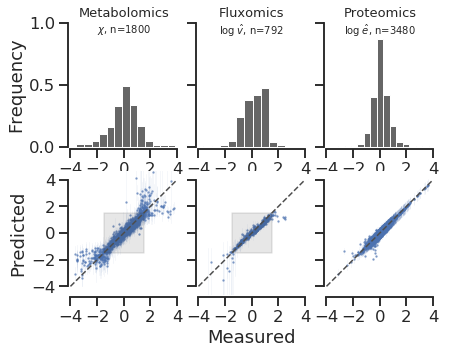

In [10]:
plt.rcParams["axes.axisbelow"] = False

fig, ax_matrix = plt.subplots(ncols=3, nrows=2, figsize=(6.5, 5),
                              sharex='row', sharey='row')

for ax in ax_matrix[1,:].flatten():
    ax.set_aspect('equal')

_ = ax_matrix[0,0].hist(xn.values.flatten(), bins=15, lw=1,
                        edgecolor='w', density=True, facecolor='.4')
_ = ax_matrix[0,1].hist(np.log(np.clip(vn.values.flatten(), 1E-8, 1E8)), bins=15, lw=1,
                        edgecolor='w', density=True, facecolor='.4')
_ = ax_matrix[0,2].hist(np.log(en.values.flatten()), bins=15, lw=1, edgecolor='w',
                        density=True, facecolor='.4')

plot_hpd(ax_matrix[1,0], xn,
         advi['trace']['chi_ss'][:, :, x_inds])
plot_hpd(ax_matrix[1,1], np.log(vn),
         np.log(np.clip(advi['trace']['vn_ss'][:, :, v_inds], 1E-8, 1E8)))
plot_hpd(ax_matrix[1,2], np.log(en),
         advi['trace']['log_en_t'][:, :, e_inds])

for ax in ax_matrix[1,:]:
    ax.set_rasterization_zorder(1)

ax_matrix[1,0].set_xlim([-4, 4])
ax_matrix[1,1].set_xlim([-4, 4])
ax_matrix[1,2].set_xlim([-4, 4])
ax_matrix[1,0].set_ylim([-4, 4])
ax_matrix[1,1].set_ylim([-4, 4])
ax_matrix[1,2].set_ylim([-4, 4])

for ax in ax_matrix[0,:]:
    ax.set_xlim([-4, 4])
    ax.set_xticks([-4, -2, 0, 2, 4])

for ax in ax_matrix[1,:]:
    ax.plot([-4, 4], [-4, 4], '--', color='.3', zorder=4, lw=1.5)
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])

    ax.set_xticks([-4, -2, 0, 2, 4])
    ax.set_yticks([-4, -2, 0, 2, 4])
    
    
ax_matrix[1,0].fill_between([-1.5, 1.5], [1.5, 1.5], [-1.5, -1.5], zorder=4, color='k', alpha=.1)
ax_matrix[1,1].fill_between([-1.5, 1.5], [1.5, 1.5], [-1.5, -1.5], zorder=4, color='k', alpha=.1)

ax_matrix[0, 0].set_ylim([0, 1.])

ax_matrix[0,0].set_title('Metabolomics', fontsize=13)
ax_matrix[0,1].set_title('Fluxomics', fontsize=13)
ax_matrix[0,2].set_title('Proteomics', fontsize=13)


ax_matrix[0,0].text(0.5, 1., '$\chi$, n={}'.format(xn.shape[0] * xn.shape[1]),
                    ha='center', va='top', transform=ax_matrix[0,0].transAxes)
ax_matrix[0,1].text(0.5, 1., '$\log\; \hat{v}$, n='+ str(vn.shape[0] * vn.shape[1]),
                    ha='center', va='top', transform=ax_matrix[0,1].transAxes)
ax_matrix[0,2].text(0.5, 1., '$\log\; \hat{e}$, n=' + str(en.shape[0] * en.shape[1]),
                    ha='center', va='top', transform=ax_matrix[0,2].transAxes)

ax_matrix[0,1].set_xlabel('Measured')
ax_matrix[-1,1].set_xlabel('Measured')
ax_matrix[1,0].set_ylabel('Predicted')
ax_matrix[0,0].set_ylabel('Frequency')

sns.despine(offset=2.5, trim=True)
# plt.tight_layout()

# plt.savefig('hackett_posterior_and_dists.svg', dpi=300)

In [11]:
from sklearn.metrics import mean_absolute_error

In [12]:
np.nanmedian((xn[(xn <= 1.5) & (xn >= -1.5)] - np.median(trace['chi_ss'][:, :, x_inds], 0)).abs().values)

0.12381674490030813

In [13]:
np.nanmedian((np.log(vn)[(np.log(vn) <= 1.5) & (np.log(vn) >= -1.5)]
             - np.median(np.log(np.clip(trace['vn_ss'][:, :, v_inds], 1E-8, 1E8)), 0)).abs().values)

0.09519013461679515

In [14]:
np.nanmedian((np.log(en)[(np.log(en) <= 1.5) & (np.log(en) >= -1.5)]
             - np.median(trace['log_en_t'][:, :, e_inds], 0)).abs().values)

0.018635254208636376

In [15]:
e_unmeasured_hpd = pm.hpd(trace['log_e_unmeasured'])
e_consistent = np.sign(e_unmeasured_hpd[:, :, 0]) == np.sign(e_unmeasured_hpd[:, :, 1])

In [16]:
e_consistent.any(0)  # 25/50 enzymes are nonzero at least once.

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [17]:
capacity_hpd = pm.hpd(trace['ex_capacity_entries'])

In [18]:
capacity_consistent = np.sign(capacity_hpd[:, 0]) == np.sign(capacity_hpd[:, 1])

In [19]:
capacity_consistent.sum()

153

In [20]:
capacity_consistent.sum() / len(capacity_consistent)

0.006460057422732647

In [21]:
e_laplace_inds

array([  5,  16,  25,  47,  66,  72,  75,  77,  80,  82,  96, 111, 112,
       115, 122, 123, 124, 125, 131, 152, 205, 206, 207, 208, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
       224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234])

Here I compare the flux control coefficients as calculated via the least-norm linear solve to those calculated via a traditional link matrix method.

In [22]:
ll_link = emll.LinLogLinkMatrix(ll.N, ll.Ex, ll.Ey, ll.v_star)

In [23]:
fccs = np.array([ll.flux_control_coefficient(Ex=ex) for ex in tqdm(advi['trace']['Ex'])])
fccs_link = np.array([ll_link.flux_control_coefficient(Ex=ex) for ex in tqdm(advi['trace']['Ex'])])

100%|██████████| 500/500 [00:06<00:00, 73.66it/s]


In [24]:
fccs.shape

(500, 240, 240)

In [25]:
r_med = np.median(fccs, 0).flatten()
l_med = np.median(fccs_link, 0).flatten()

r_err = [r_med - np.percentile(fccs, 25, axis=0).flatten(), np.percentile(fccs, 75, axis=0).flatten() - r_med]
l_err = [l_med - np.percentile(fccs_link, 25, axis=0).flatten(), np.percentile(fccs_link, 75, axis=0).flatten() - l_med]

Text(1,-1,'$\\rho = 0.82$')

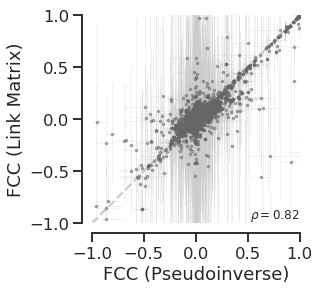

In [26]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='box')

ax.set_aspect('equal')
ax.errorbar(r_med, l_med, ms=5, lw=0, xerr=r_err, yerr=l_err, marker='.', color='.4', zorder=3, alpha=0.5)
ax.errorbar(r_med, l_med, ms=5, lw=0, xerr=r_err, yerr=l_err, elinewidth=.5, color='.8', alpha=0.5, zorder=2)

ax.plot([-5, 5], [-5, 5], '--', color='.8', zorder=0)

ax.set_xlabel('FCC (Pseudoinverse)')
ax.set_ylabel('FCC (Link Matrix)')

ax.set_rasterization_zorder(4)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])


plt.tight_layout()
sns.despine(trim=True, offset=10)
ax.text(1, -1, '$\\rho = {:.2f}$'.format(pd.Series(r_med).corr(pd.Series(l_med))), ha='right', va='bottom', fontsize=12)

# plt.savefig('fcc_comparison.svg', dpi=300)

In [27]:
fcc_med = np.median(fccs, 0)
fcc_med = pd.DataFrame(fcc_med, columns=r_labels, index=r_labels)

In [31]:
def corrwith(left, right, df=True):
    # demeaned data
    left_tiled = np.repeat(left.values[:, np.newaxis, :], right.shape[0], 1)
    right_tiled = np.repeat(right.values[np.newaxis, :, :], left.shape[0], 0)

    ldem = left_tiled - left_tiled.mean(-1)[:, :, np.newaxis]
    rdem = right_tiled - right_tiled.mean(-1)[:, :, np.newaxis]

    num = (ldem * rdem).sum(-1)

    dom = (left.shape[1] - 1) * left_tiled.std(-1) * right_tiled.std(-1)
    correl = num / dom
    
    if not df:
        return correl
    else: 
        return pd.DataFrame(correl, index=left.index, columns=right.index)

corr_df = corrwith(e, v).T

In [32]:
def random_corr_iterator():
    return corrwith(e.loc[:, np.random.permutation(e.columns)],
                    v.loc[:, np.random.permutation(e.columns)], df=False)

In [33]:
permuted_corr_mat = np.array([random_corr_iterator() for _ in tqdm(range(2000))])

100%|██████████| 2000/2000 [00:06<00:00, 287.13it/s]


In [36]:
import scipy
from scipy import cluster

z_scores = (corr_df - permuted_corr_mat.mean(0).T) / permuted_corr_mat.std(0).T
p_vals = 2 * z_scores.abs().apply(scipy.stats.norm.sf)

def sort_df(df):
    sort_x = cluster.hierarchy.leaves_list(cluster.hierarchy.linkage(df, "complete"))
    sort_y = cluster.hierarchy.leaves_list(cluster.hierarchy.linkage(df.T, "complete"))
    
    return df.iloc[sort_x, sort_y]

In [37]:
fccs_hpd = pm.hpd(fccs)
fcc_consistent = np.sign(fccs_hpd[:, :, 0]) == np.sign(fccs_hpd[:, :, 1])
fcc_consistent_df = pd.DataFrame(fcc_consistent, columns=r_labels, index=r_labels)

sorted_corr_df = sort_df(corr_df)

fcc_med_measured = fcc_med.reindex(columns=sorted_corr_df.columns, index=sorted_corr_df.index)
fcc_consistent_measured = fcc_consistent_df.reindex(columns=sorted_corr_df.columns, index=sorted_corr_df.index)

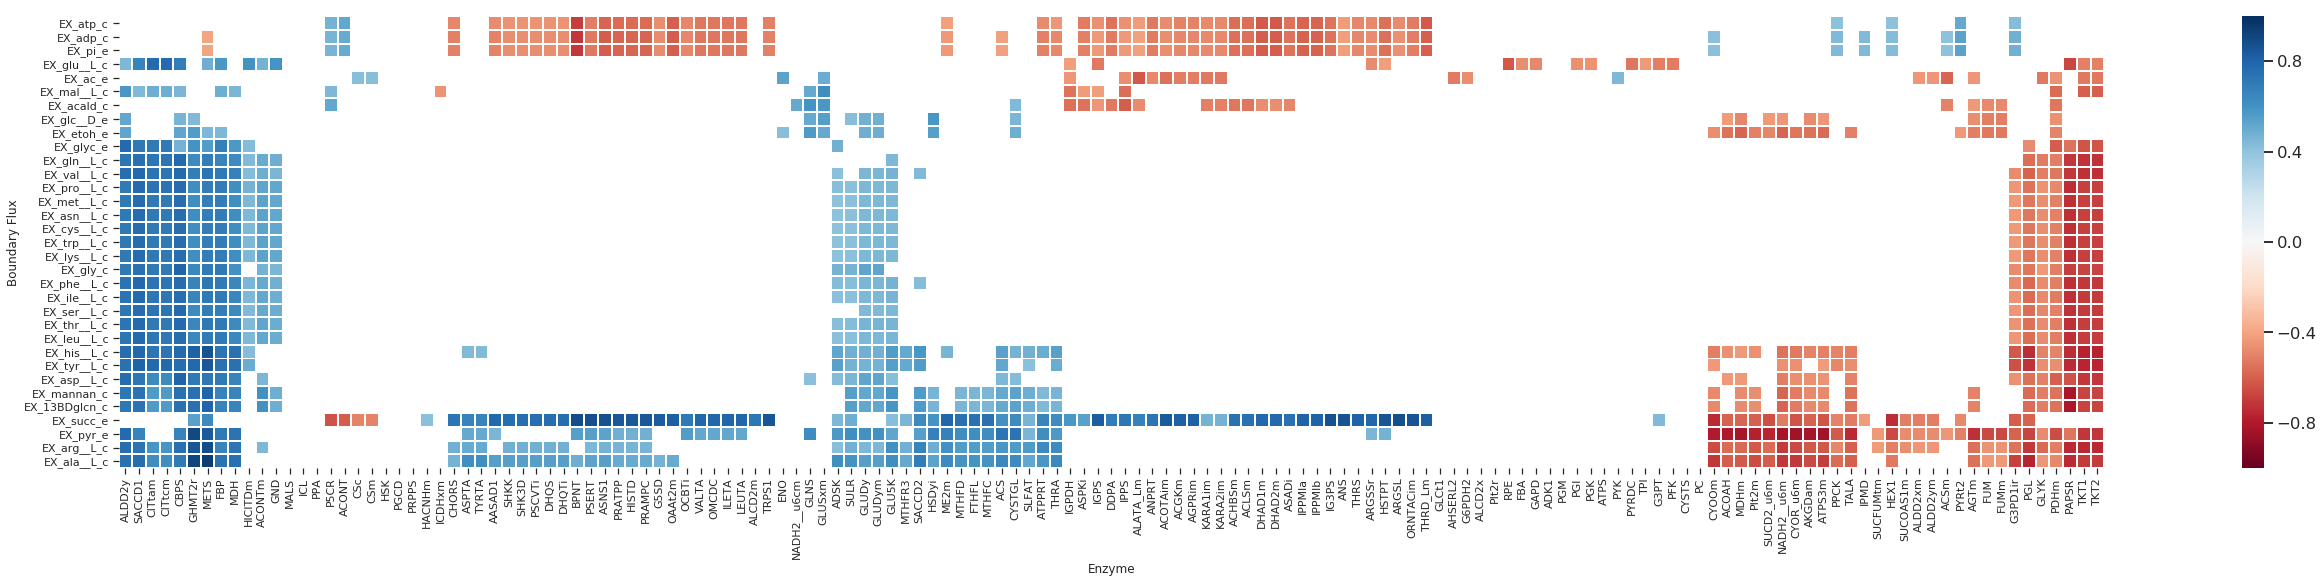

In [39]:
with sns.plotting_context('notebook'):
    fig = plt.figure(figsize=(40,8))
    ax = fig.add_subplot(111, aspect='equal', adjustable='box')

sns.heatmap(sorted_corr_df[p_vals < 0.05].values, vmin=-1, vmax=1, cmap='RdBu', cbar=True, rasterized=True, lw=1)


# xticks = np.arange(0, sorted_corr_df.shape[1], 25)
# _= ax.set_xticks(xticks + 0.5)
# _= ax.set_xticklabels(xticks)


# yticks = np.arange(0, sorted_corr_df.shape[0], 10)
# _= ax.set_yticks(yticks + 0.5)
# _= ax.set_yticklabels(yticks)


_= ax.set_yticks(np.arange(sorted_corr_df.shape[0]) + 0.5)
_= ax.set_xticks(np.arange(sorted_corr_df.shape[1]) + 0.5)
_ = ax.set_yticklabels(sorted_corr_df.index, rotation=0)
_ = ax.set_xticklabels(sorted_corr_df.columns)

ax.set_xlabel('Enzyme')
ax.set_ylabel('Boundary Flux')

plt.tight_layout()
# plt.savefig('corr_heatmap_large_confident.svg', dpi=75)

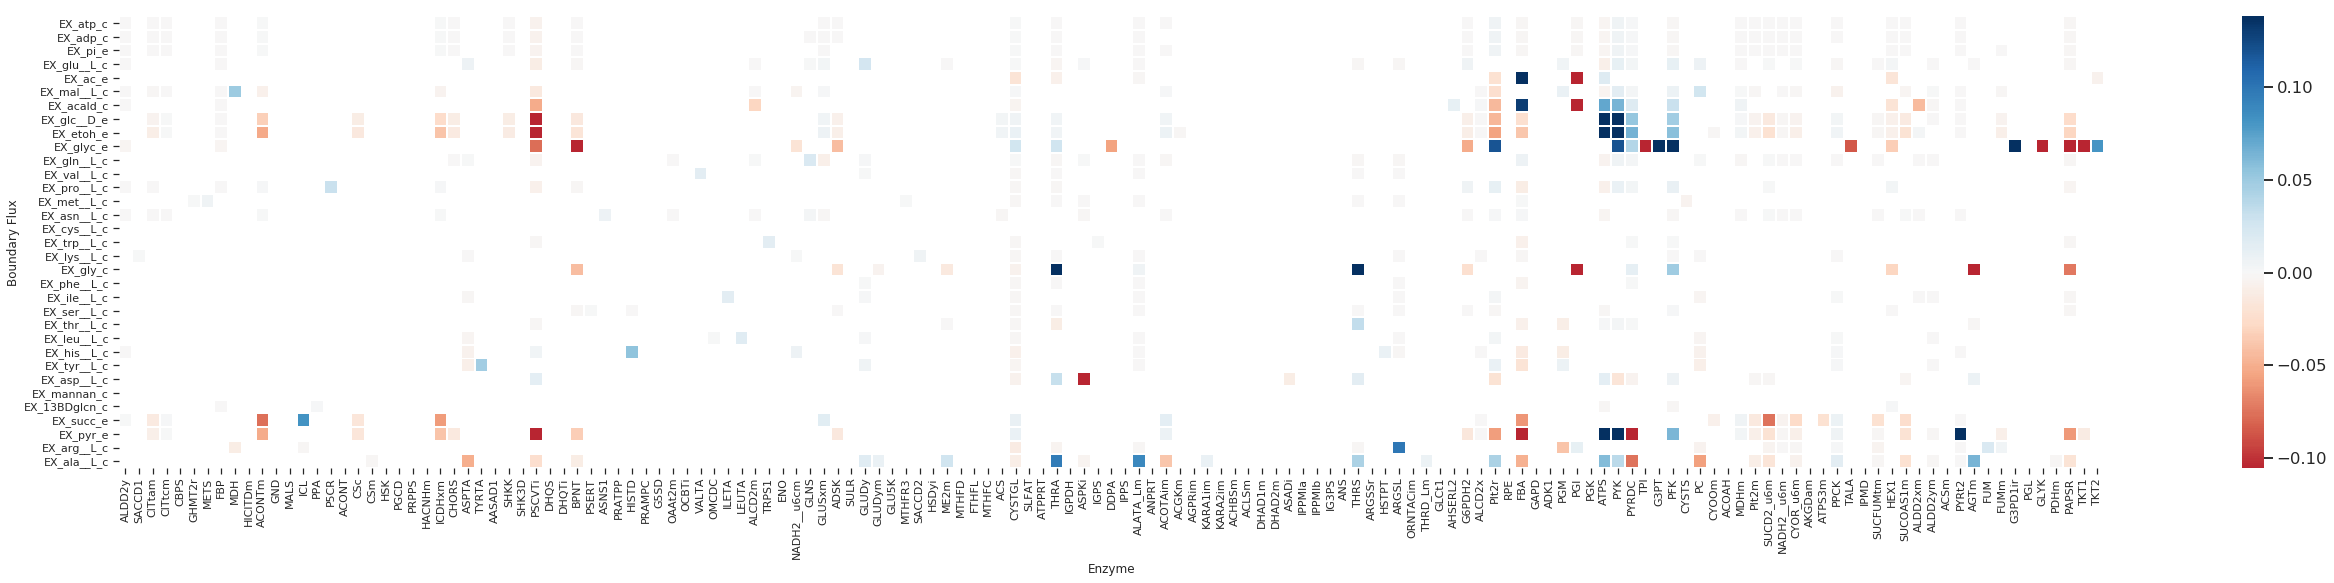

In [40]:
with sns.plotting_context('notebook'):

    fig = plt.figure(figsize=(40,8))
    ax = fig.add_subplot(111, aspect='equal', adjustable='box')

sns.heatmap(fcc_med_measured[fcc_consistent_measured].values,
            center=0, robust=True, cmap='RdBu', cbar=True, rasterized=True, lw=1)


# xticks = np.arange(0, sorted_corr_df.shape[1], 25)
# _= ax.set_xticks(xticks + 0.5)
# _= ax.set_xticklabels(xticks)


# yticks = np.arange(0, sorted_corr_df.shape[0], 10)
# _= ax.set_yticks(yticks + 0.5)
# _= ax.set_yticklabels(yticks)


_= ax.set_yticks(np.arange(sorted_corr_df.shape[0]) + 0.5)
_= ax.set_xticks(np.arange(sorted_corr_df.shape[1]) + 0.5)
_ = ax.set_yticklabels(sorted_corr_df.index, rotation=0)
_ = ax.set_xticklabels(sorted_corr_df.columns)

ax.set_xlabel('Enzyme')
ax.set_ylabel('Boundary Flux')

plt.tight_layout()
# plt.savefig('fcc_heatmap_large.svg', dpi=75)